### Example of using the Bayesian optimisation package in 1D. This script utilises batch sampling, but not bounds reduction or sub-batch sampling.

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as con
import sys
import os

sys.path.append('..')
import BOPackage

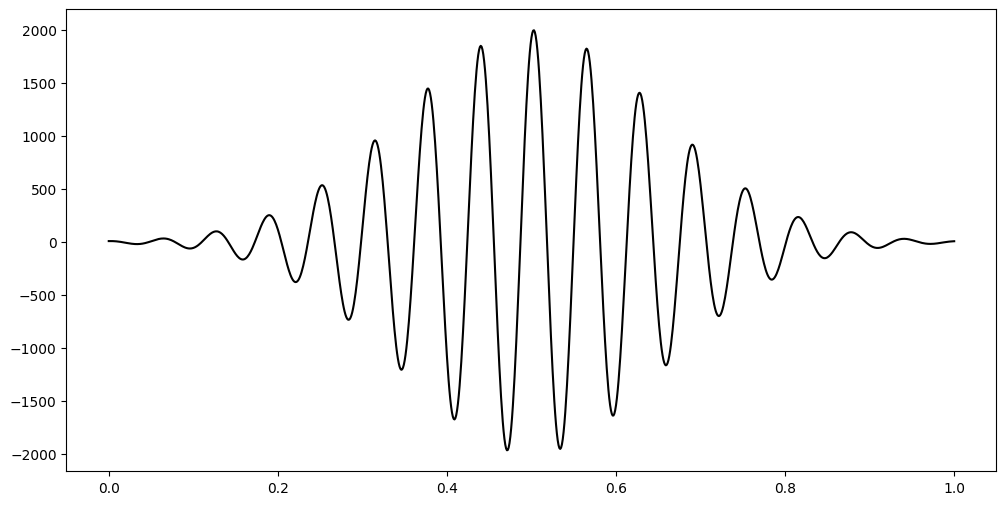

In [48]:
"""
Define the objective function.
"""

def ObjectiveFunction(x):
    x_centre = 0.5
    FWHM = 0.3
    width = FWHM / (2 * np.log(2))

    spatial_intensity =  np.exp(- ((x - x_centre) / width)**2)

    return 2000 * np.cos(100 * x) * spatial_intensity

X = np.linspace(0, 1, 1001, endpoint=True).reshape(1001, 1)

plt.figure(figsize=(12, 6))

plt.plot(X[:, 0], ObjectiveFunction(X), color='k')

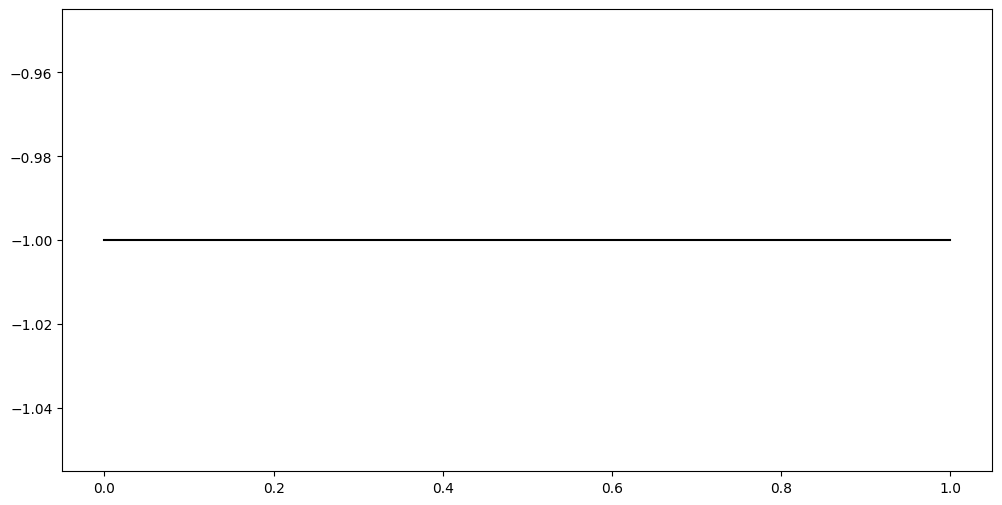

In [49]:
def PriorMeanFunction(X):
    return - np.ones(len(X)).reshape(len(X), 1)

plt.figure(figsize=(12, 6))

plt.plot(X[:, 0], PriorMeanFunction(X), color='k')

In [50]:
"""
Configure the optimiser.
"""
PriorMean = PriorMeanFunction
Kernel = BOPackage.RBF_Kernel_CPU
# Kernel = BOPackage.MaternKernel
length_scale = 0.005500045             # Note, the length scale is the length scale after standardisation (setting the mean to 0 and standard deviation to 1)

AcquisitionFunction = BOPackage.UpperConfidenceBound
max_kappa = 10                  # Maximum kappa value used in the acquisition function for the batch
min_kappa = 0.1                 # Minimum kappa value used in the acquisition function for the batch

bounds = np.array([[0, 1]])
acquisition_samples = 1000        # Number of random points in the domain to calculate the acqusition function value at. The point with the highest acquisition function value will be added to the raw_X for the batch

random_seed = None                # random seed for reproducability if wanted. 

# Create the object
bo = BOPackage.BO(PriorMeanFunction=PriorMean,
                  KernelFunction=Kernel, 
                  length_scale=length_scale, 
                  AcquisitionFunction=AcquisitionFunction, 
                  bounds=bounds, 
                  acquisition_samples=acquisition_samples,
                  random_seed=random_seed)

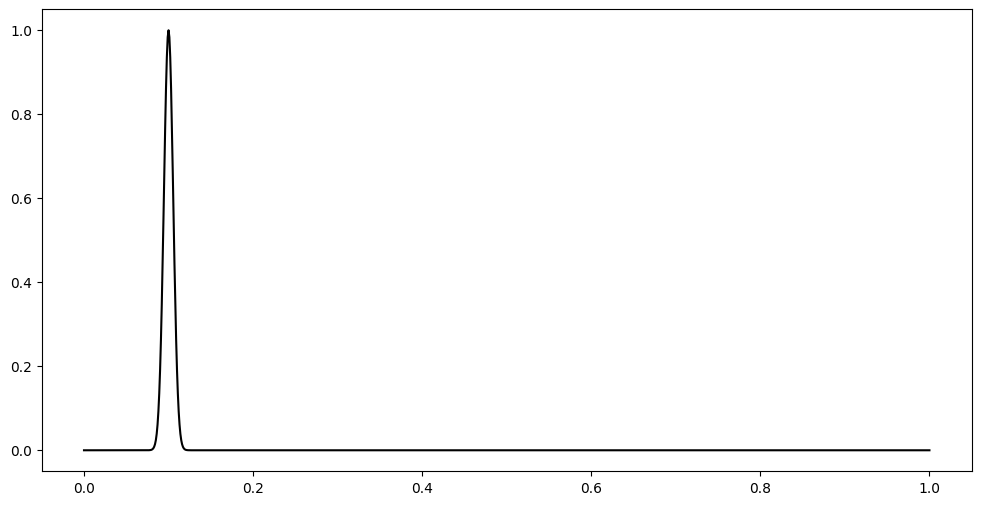

In [51]:
test_X = np.array([[0.1]])
kernel_example = bo.Kernel(test_X, X, length_scales=length_scale)

plt.figure(figsize=(12, 6))

plt.plot(X, kernel_example[0, :], color='k')

In [52]:
"""
Get first random batch and update the optimiser.
"""

raw_X = bo.GetRandomXBatch(batch_size=4)
raw_Y = ObjectiveFunction(raw_X)
bo.UpdateData(raw_X, raw_Y)

bo.X_data, bo.y_data

(array([[0.0190928 ],
        [0.60605906],
        [0.68340146],
        [0.82998743]]),
 array([[  -4.75882181],
        [-958.36419191],
        [ 696.78577802],
        [  49.02923627]]))

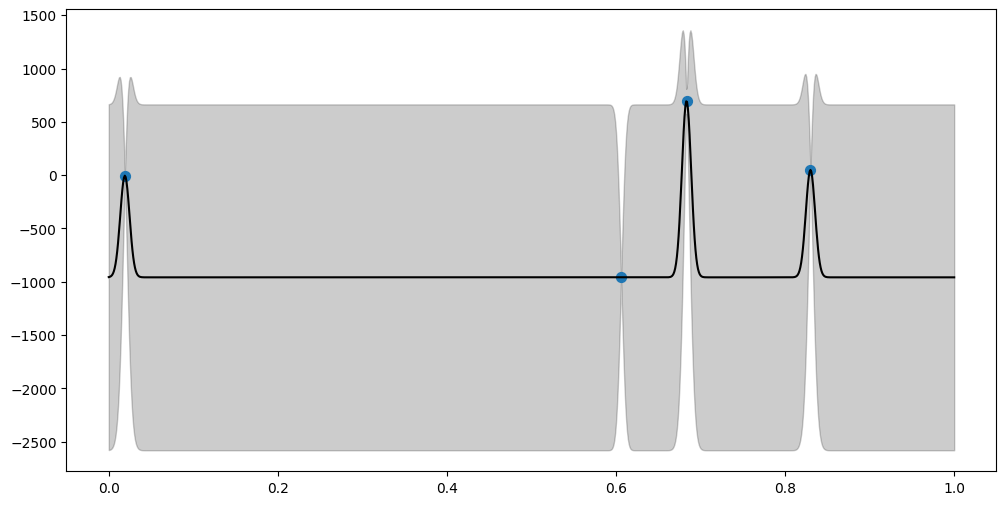

In [53]:
"""
Can then visualise the mean and variance over the parameter
using the true y values.
"""

mean, variance = bo.PredictMeanVariance(X, normalised=False)

plt.figure(figsize=(12, 6))

# # Plot the mean and the confidence interval
plt.plot(X, mean, label='mean', color='k')
plt.fill_between(X[:,0], mean[:,0] - 1.96 * np.sqrt(variance[:,0]), mean[:,0] + 1.96 * np.sqrt(variance[:,0]), color = 'k', alpha=0.2, label = '95% confidence interval')

# Scatter plot of X_data and y_data
plt.scatter(bo.X_data, bo.y_data, s=50)

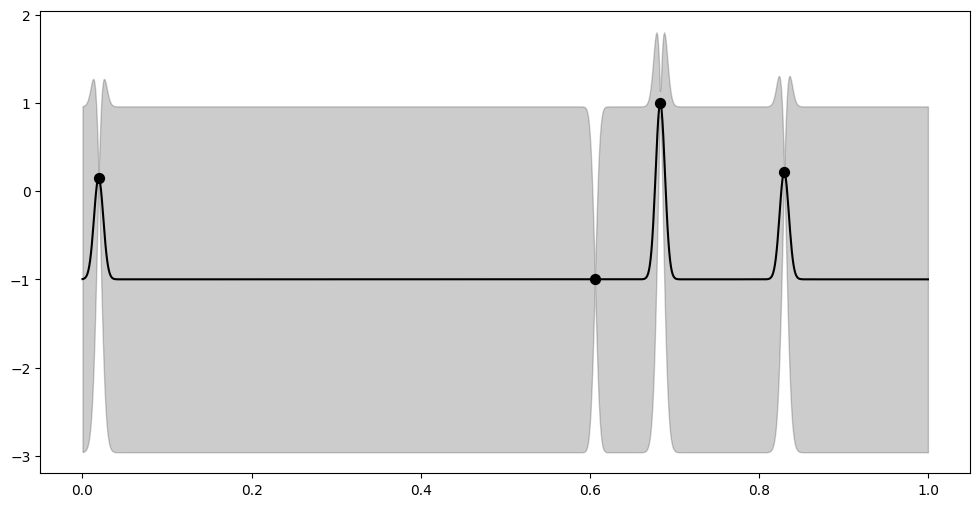

In [54]:
"""
Or can visualise the mean and variance over the parameter
using the normalised y values (which the code uses).
"""

if np.max(bo.y_data) - np.min(bo.y_data) != 0.0:
    normalised_y_data = 2 * (bo.y_data - np.min(bo.y_data)) / (np.max(bo.y_data) - np.min(bo.y_data)) - 1
else:
    normalised_y_data = bo.y_data

if bo.minimise is True:
    normalised_y_data = -normalised_y_data

normalised_mean, normalised_variance = bo.PredictMeanVariance(X, normalised=True)


plt.figure(figsize=(12, 6))

# Plot the mean and the confidence interval
plt.plot(X, normalised_mean, label='mean', color='k')
plt.fill_between(X[:,0], normalised_mean[:,0] - 1.96 * np.sqrt(normalised_variance[:,0]), normalised_mean[:,0] + 1.96 * np.sqrt(normalised_variance[:,0]), color = 'k', alpha=0.2, label = '95% confidence interval')

# Scatter plot of X_data and y_data
plt.scatter(bo.X_data, normalised_y_data, s=50, color='k')

<Figure size 1200x600 with 0 Axes>

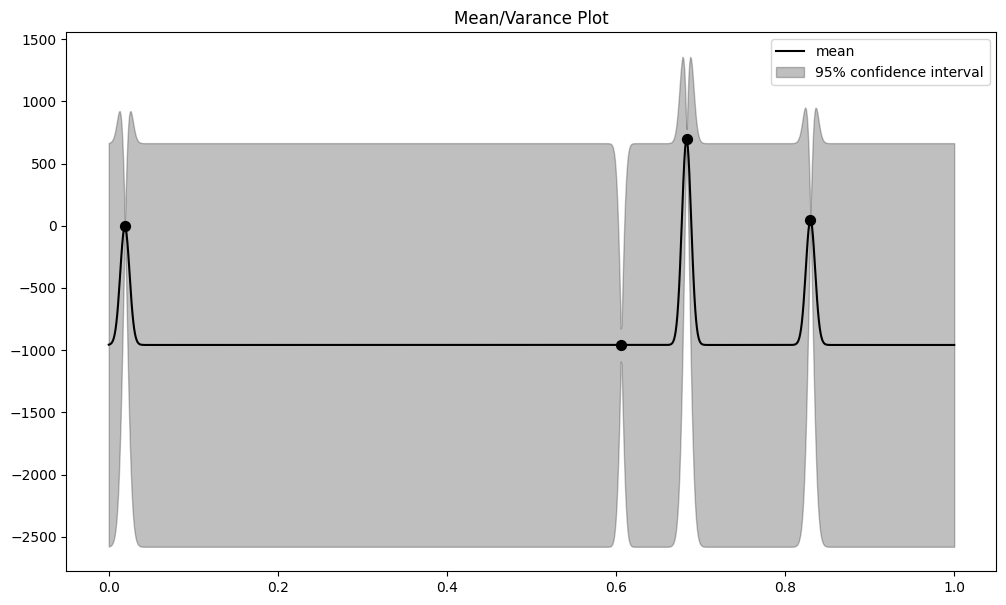

In [55]:
"""
Take a look at the mean and variance of the function now we have some data
using the function defined in the package.
"""

BOPackage.SausagePlot(bo, normalised=False)

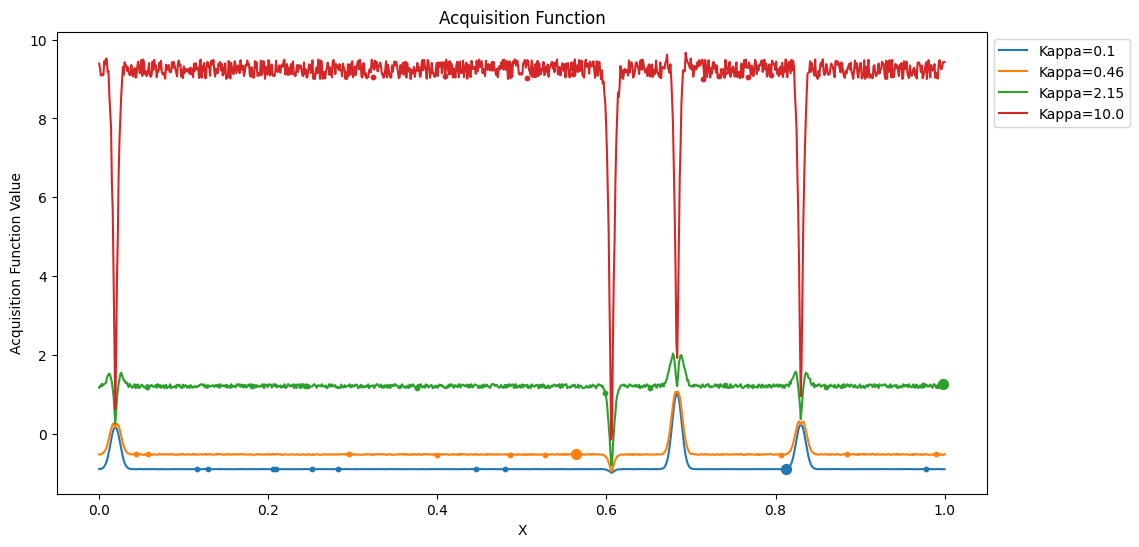

In [56]:
"""
Plot the Acquisition function for a range of kappas and demonstrate how the next point is selected.

'n_sample' random X values are selected and the one which returns the largest acqusition function value
is chosen for each kappa value. Assuming no 'sub batches' are used, there will be 'batch_size' kappa 
values and a point in X will be selected for each kappa value.
"""

raw_X = BOPackage.KappaAcquisitionFunctionPlot(bo, number_kappas=4, number_candidate_points=10, max_kappa=max_kappa, min_kappa=min_kappa)

<Figure size 1200x600 with 0 Axes>

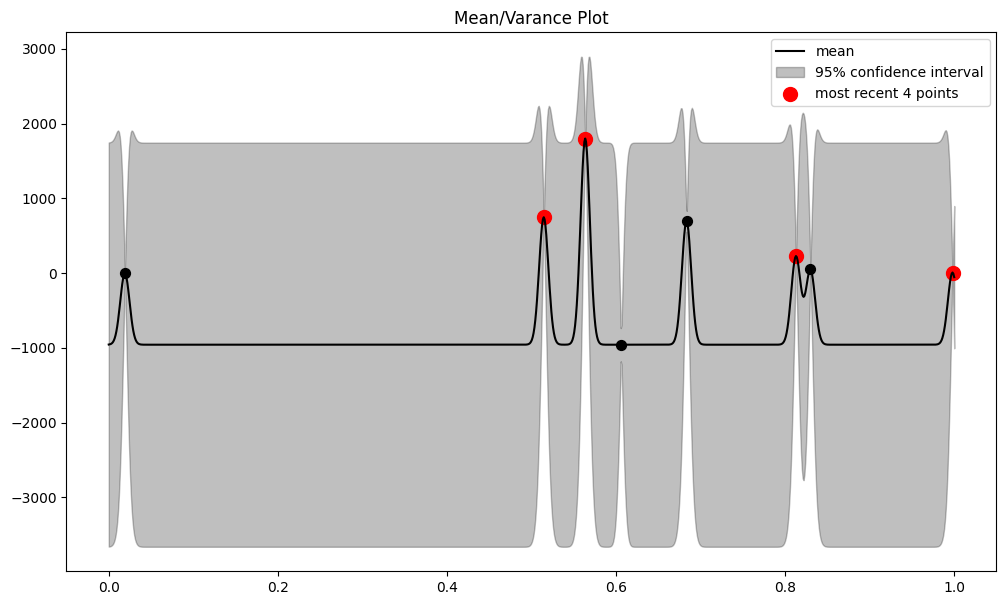

In [57]:
"""
Now select the next batch of X values using the acquisition function (not random) and update the optimiser.
"""

# batch_size = 4
# raw_X = bo.GetNextXBatch(batch_size=batch_size, max_kappa=max_kappa, min_kappa=min_kappa)
raw_Y = ObjectiveFunction(raw_X)
bo.UpdateData(raw_X, raw_Y)

BOPackage.SausagePlot(bo, highlight_recent=len(raw_X))

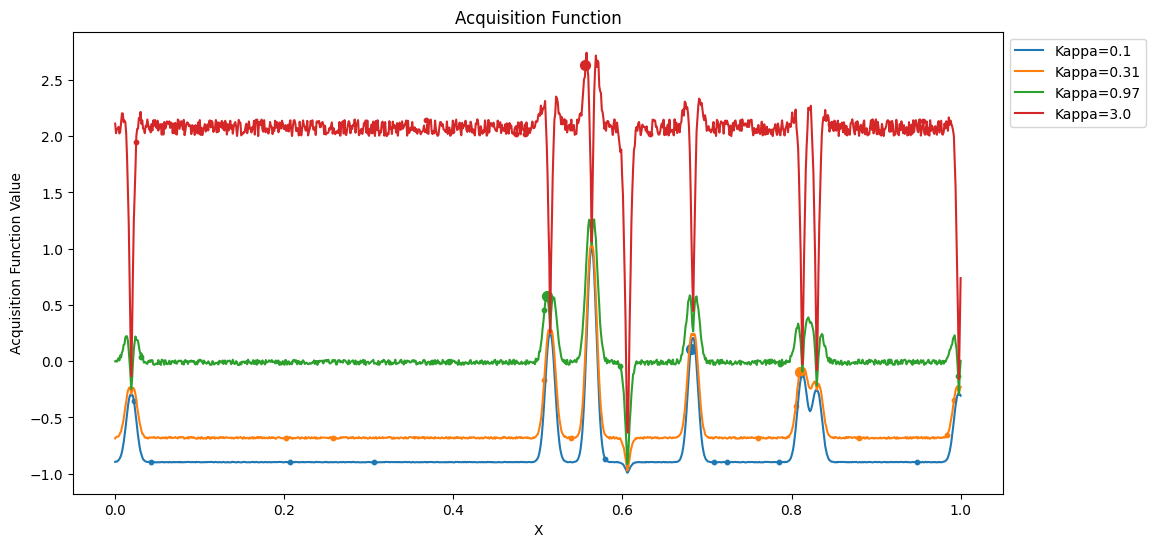

In [58]:
"""
Again lets looks at the acquisition function and how our next X set is selected.
"""
raw_X = BOPackage.KappaAcquisitionFunctionPlot(bo, number_kappas=4, number_candidate_points=10, max_kappa=3, min_kappa=0.1)

<Figure size 1200x600 with 0 Axes>

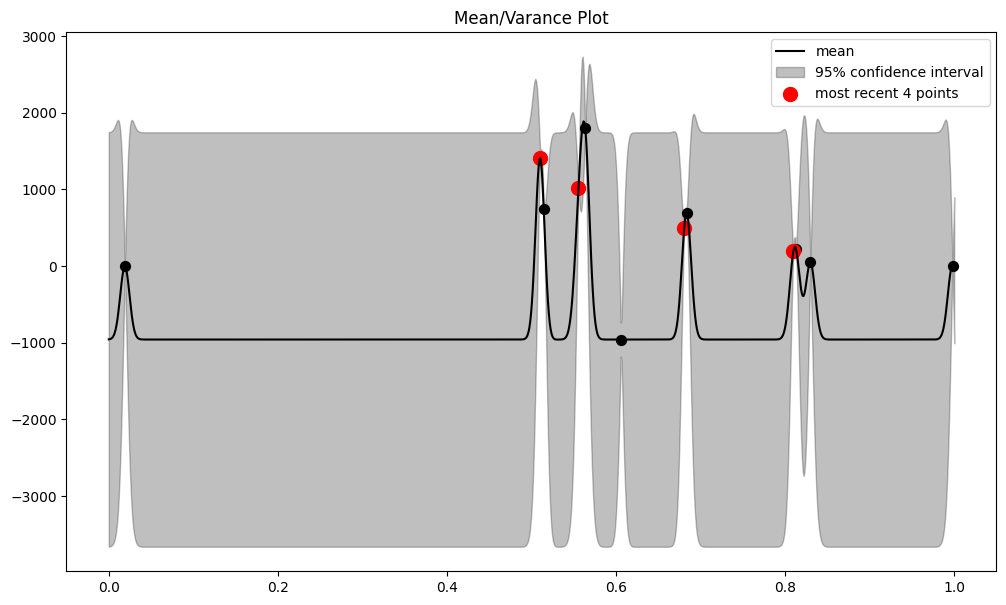

In [59]:
"""
Final example of doing this again.
"""
# batch_size = 4

# raw_X = bo.GetNextXBatch(batch_size=4, max_kappa=max_kappa, min_kappa=min_kappa)
raw_Y = ObjectiveFunction(raw_X)
bo.UpdateData(raw_X, raw_Y)

BOPackage.SausagePlot(bo, highlight_recent=len(raw_X))

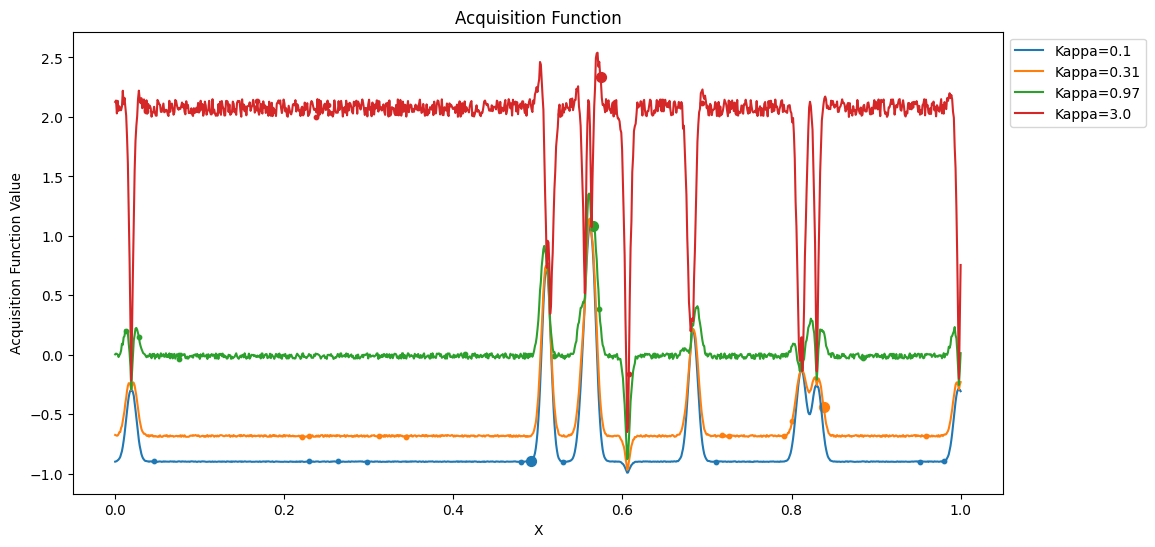

In [60]:
raw_X = BOPackage.KappaAcquisitionFunctionPlot(bo, number_kappas=4, number_candidate_points=10, max_kappa=3, min_kappa=0.1)

<Figure size 1200x600 with 0 Axes>

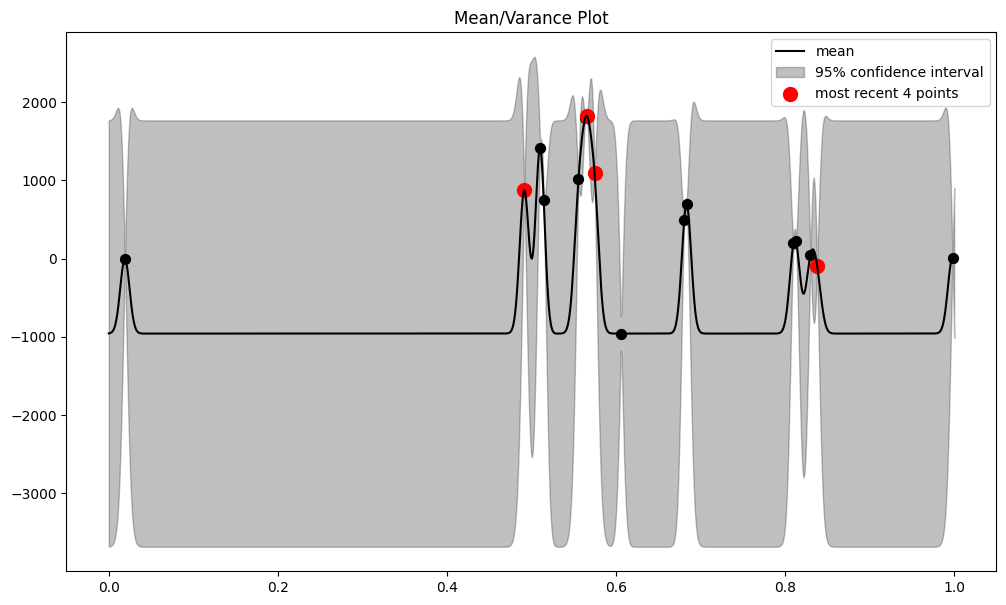

In [61]:
"""
Final example of doing this again.
"""
# batch_size = 4

# raw_X = bo.GetNextXBatch(batch_size=4, max_kappa=max_kappa, min_kappa=min_kappa)
raw_Y = ObjectiveFunction(raw_X)
bo.UpdateData(raw_X, raw_Y)

BOPackage.SausagePlot(bo, highlight_recent=len(raw_X))

<Figure size 1200x600 with 0 Axes>

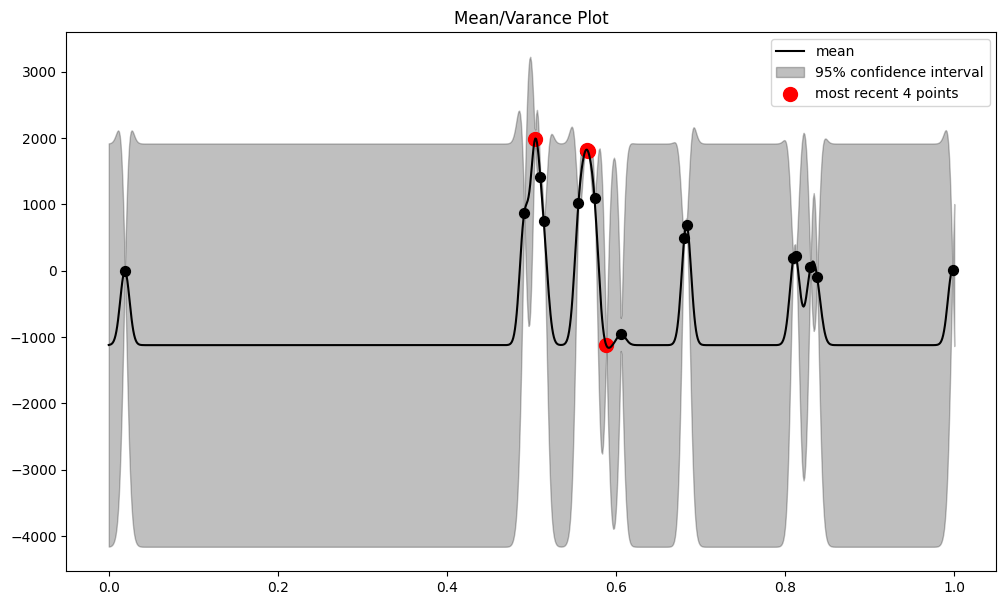

In [62]:
"""
Final example of doing this again.
"""
batch_size = 4

raw_X = bo.GetNextXBatch(batch_size=4, max_kappa=max_kappa, min_kappa=min_kappa)
raw_Y = ObjectiveFunction(raw_X)
bo.UpdateData(raw_X, raw_Y)

BOPackage.SausagePlot(bo, highlight_recent=len(raw_X))

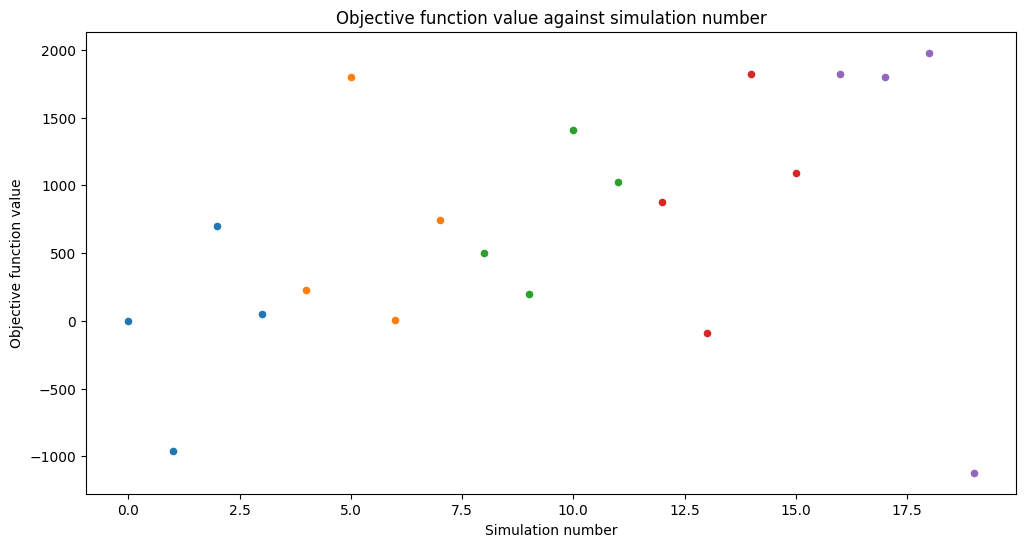

In [63]:
BOPackage.PlotData(bo)

In [64]:
def log_marginal_likelihood(X_data, Y_data, length_scale):
    K = BOPackage.RBF_Kernel_CPU(X_data, X_data, length_scale) + 1e-5 * np.eye(len(X_data))
    K_inv = np.linalg.inv(K)
    log_det_K = np.linalg.slogdet(K)[1]

    n = len(Y_data)
    
    term1 = Y_data.T @ K_inv @ Y_data
    term2 = log_det_K
    log_likelihood = -0.5 * term1 - 0.5 * term2 - 0.5 * n * np.log(2 * np.pi)

    return log_likelihood

In [65]:
array = []
for mu in np.linspace(0.0000001, 0.01, 101):
    result = log_marginal_likelihood(bo.X_data, bo.y_data, mu)
    print(mu, result)
    array.append(result)

1e-07 [[-12811795.89391042]]
0.000100099 [[-12150570.79053842]]
0.000200098 [[-11434433.23086939]]
0.000300097 [[-11275523.45237409]]
0.000400096 [[-11211701.66328739]]
0.000500095 [[-11131453.96968955]]
0.0006000939999999999 [[-10984473.74561676]]
0.0007000929999999999 [[-10768121.03271261]]
0.000800092 [[-10503802.48954477]]
0.000900091 [[-10228922.9412309]]
0.0010000900000000001 [[-9974223.97129113]]
0.001100089 [[-9752861.49440651]]
0.001200088 [[-9565311.14912528]]
0.0013000870000000001 [[-9406632.73492401]]
0.001400086 [[-9270804.75967889]]
0.0015000850000000002 [[-9152509.74696402]]
0.001600084 [[-9047573.00130058]]
0.001700083 [[-8952836.41878193]]
0.0018000820000000002 [[-8865866.82929983]]
0.001900081 [[-8784679.22030035]]
0.00200008 [[-8707539.15244237]]
0.002100079 [[-8632852.5233455]]
0.002200078 [[-8559128.43091254]]
0.0023000769999999998 [[-8484994.61369186]]
0.0024000759999999997 [[-8409244.52513066]]
0.002500075 [[-8330896.39493562]]
0.002600074 [[-8249247.01705443]]
0

In [66]:
bo.X_data

array([[0.0190928 ],
       [0.60605906],
       [0.68340146],
       [0.82998743],
       [0.81281281],
       [0.56356356],
       [0.997998  ],
       [0.51451451],
       [0.68068068],
       [0.80980981],
       [0.51051051],
       [0.55555556],
       [0.49149149],
       [0.83783784],
       [0.56556557],
       [0.57457457],
       [0.56539834],
       [0.56690641],
       [0.50407277],
       [0.58843578]])